This script evaluates the improvements against the algorithm shown at the intermediate presentation.
Concretely, we show
- the huffman multicut VS the multicut aware codec
- the huffman multicut VS the border codec
- the improvement of the hybrid vs the multicut aware and border codec
- the improvement of the custom color encoding vs the naive one

In [1]:
from mlcv_py import make_mask_with_size, encode_mask_with_size
from mlcv_py import MULTICUT_CODEC as mc, PARTITION_CODEC as pc, OPTIMIZER as opt
import cv2
from pathlib import Path
import shutil
from tqdm import tqdm
from functools import partial
from batch import batch_execute

In [2]:
def run(imgs, mc_algorithm, quality: float):
    inputs = [(img, mc_algorithm, pc.SIMPLE, opt.GREEDY_GRID, quality) for img in imgs]
    return batch_execute("make_mask_with_size", inputs, cpu_count=2)

In [3]:
QUALITY_LEVELS = [1, 25, 50]
SRC_ROOT = Path("../data/splitimages/test")

In [4]:
def compute_mask_sizes(algorithm, quality):
    ans = dict()
    for category_dir in tqdm(SRC_ROOT.glob("*")):
        if not category_dir.is_dir(): continue
        imgs = [cv2.imread(str(img_p), cv2.IMREAD_COLOR) for img_p in category_dir.glob("*.png")]
        ans[category_dir.name] = [t[1] for t in run(imgs, algorithm, quality)]
    return ans

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compare_results(size_results1, size_results2, algorithm1_name, algorithm2_name, save_path=None, size_results3=None, algorithm3_name=None):
    """
    Compare compression results by category, plot a bar chart with relative reduction, and optionally save the chart.

    Args:
        size_results1 (dict): A dictionary mapping category names to a list of sizes (bits) for the first algorithm.
        size_results2 (dict): A dictionary mapping category names to a list of sizes (bits) for the second algorithm.
        algorithm1_name (str): Name of the first algorithm (baseline).
        algorithm2_name (str): Name of the second algorithm.
        save_path (str, optional): File path to save the chart. If None, the chart is not saved.
        size_results3 (dict, optional): A dictionary mapping category names to a list of sizes (bits) for the third algorithm.
        algorithm3_name (str, optional): Name of the third algorithm.
    """
    # Ensure all dictionaries have the same keys
    categories = sorted(set(size_results1.keys()).intersection(size_results2.keys()))
    
    # Calculate total sizes for each category
    total_sizes1 = [sum(size_results1[category]) for category in categories]
    total_sizes2 = [sum(size_results2[category]) for category in categories]
    if size_results3:
        total_sizes3 = [sum(size_results3[category]) for category in categories]
    
    # Calculate relative reduction for algorithm 2 and optionally algorithm 3 compared to algorithm 1
    relative_reduction2 = [(size2 / size1) * 100 for size1, size2 in zip(total_sizes1, total_sizes2)]
    if size_results3:
        relative_reduction3 = [(size3 / size1) * 100 for size1, size3 in zip(total_sizes1, total_sizes3)]

    # Create a DataFrame for seaborn
    data = pd.DataFrame({
        'Category': categories,
        algorithm1_name: [100] * len(categories),  # Baseline is always 100%
        algorithm2_name: relative_reduction2
    })
    if size_results3:
        data[algorithm3_name] = relative_reduction3

    # Melt the DataFrame for easier plotting with seaborn
    data_melted = data.melt(id_vars='Category', var_name='Algorithm', value_name='Relative Size (%)')

    # Plot the bar chart
    plt.figure(figsize=(12, 8))  # Adjusted width and height for better spacing
    sns.barplot(
        data=data_melted, 
        x='Category', 
        y='Relative Size (%)', 
        hue='Algorithm', 
        palette='viridis', 
        dodge=True  # Ensures bars are separated within each category
    )
    plt.xlabel('Category')
    plt.ylabel('Relative Größe')
    plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.legend(
        title='Algorithmus', 
        loc='upper left', 
        bbox_to_anchor=(1.02, 1),  # Move legend outside the plot
        borderaxespad=0
    )
    plt.tight_layout(pad=2.0)  # Add padding for better spacing

    # Save the chart if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    else:
        plt.show()

In [6]:
sizes_huff_1 = compute_mask_sizes(mc.HUFFMAN, 1)
sizes_border_1 = compute_mask_sizes(mc.BORDER, 1)
sizes_multicut_aware_1 = compute_mask_sizes(mc.MULTICUT_AWARE, 1)
sizes_ensemble_1  = compute_mask_sizes(mc.ENSEMBLE, 1)

Processing: 100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
13it [02:30, 11.61s/it]
Processing: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]
13it [04:12, 19.41s/it]
Processing: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]
13it [03:47, 17.49s/it]
Processing: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]
13it [03:53, 17.98s/it]


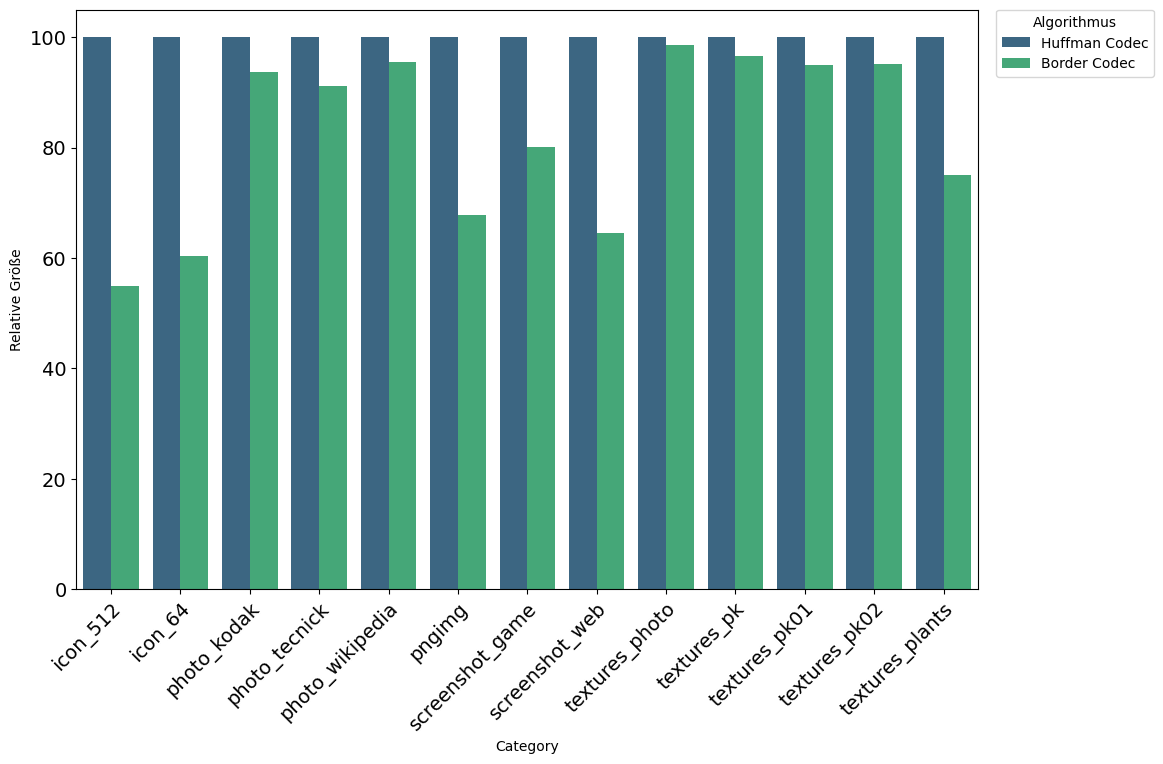

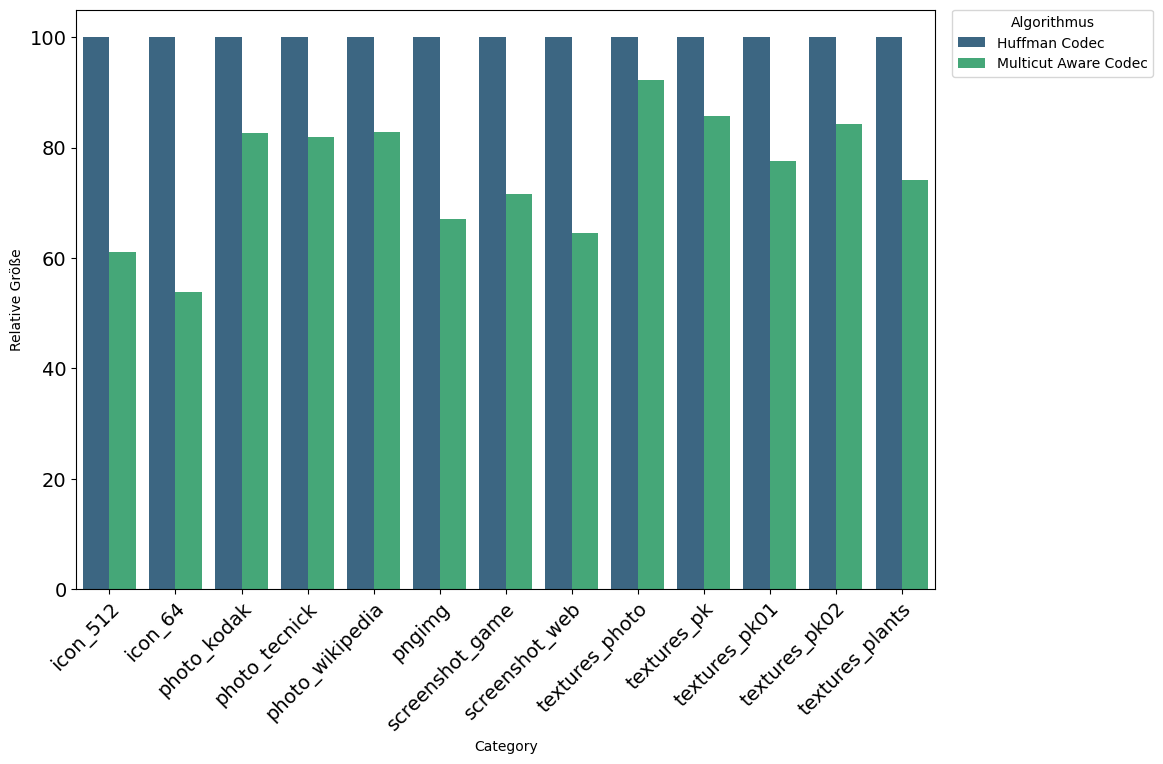

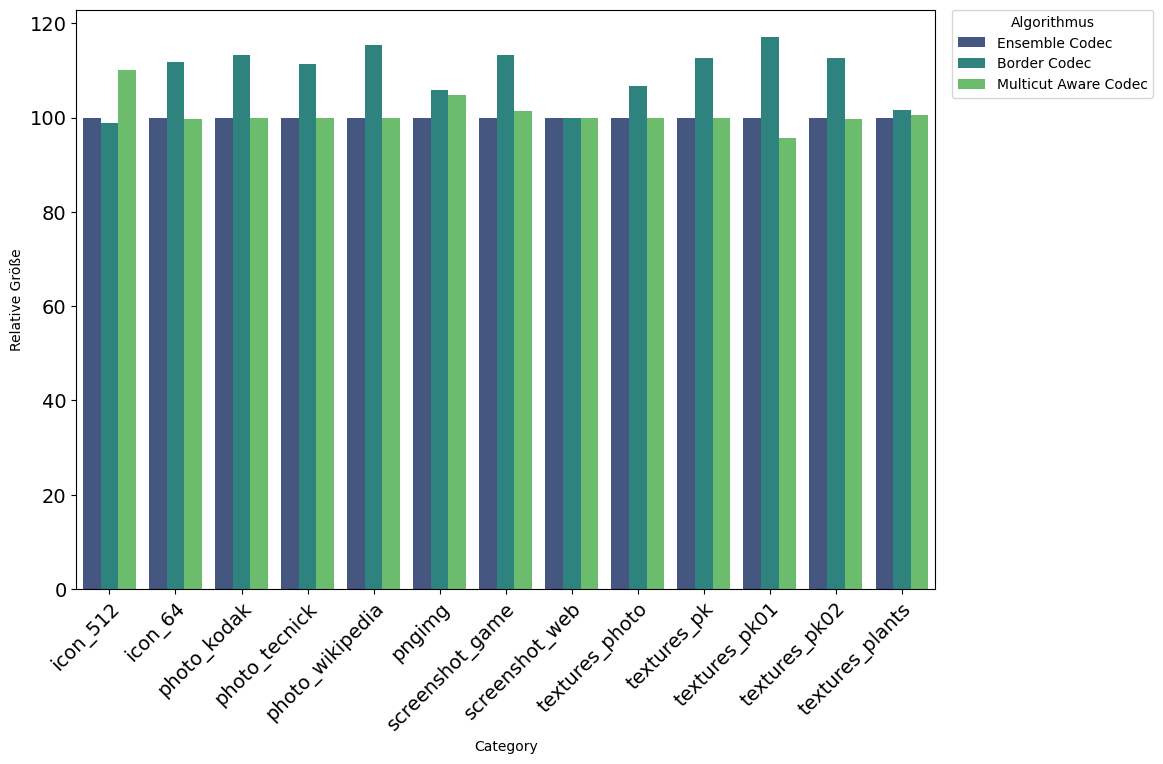

In [7]:
qname = "high"
compare_results(sizes_huff_1, sizes_border_1, "Huffman Codec", "Border Codec", f"multicut-comparisons/huff_v_border_{qname}.png")
compare_results(sizes_huff_1, sizes_multicut_aware_1, "Huffman Codec", "Multicut Aware Codec", f"multicut-comparisons/huff_v_multicut_aware_{qname}.png")
compare_results(sizes_ensemble_1, sizes_border_1, "Ensemble Codec", "Border Codec", f"multicut-comparisons/ensemble_v_border_v_multicut{qname}.png", 
                sizes_multicut_aware_1, "Multicut Aware Codec")

In [8]:
sizes_huff_25 = compute_mask_sizes(mc.HUFFMAN, 25)
sizes_border_25 = compute_mask_sizes(mc.BORDER, 25)
sizes_multicut_aware_25 = compute_mask_sizes(mc.MULTICUT_AWARE, 25)
sizes_ensemble_25  = compute_mask_sizes(mc.ENSEMBLE, 25)

Processing: 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]
13it [02:01,  9.34s/it]
Processing: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
13it [03:26, 15.85s/it]
Processing: 100%|██████████| 18/18 [00:07<00:00,  2.28it/s]
13it [03:05, 14.26s/it]
Processing: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
13it [03:22, 15.57s/it]


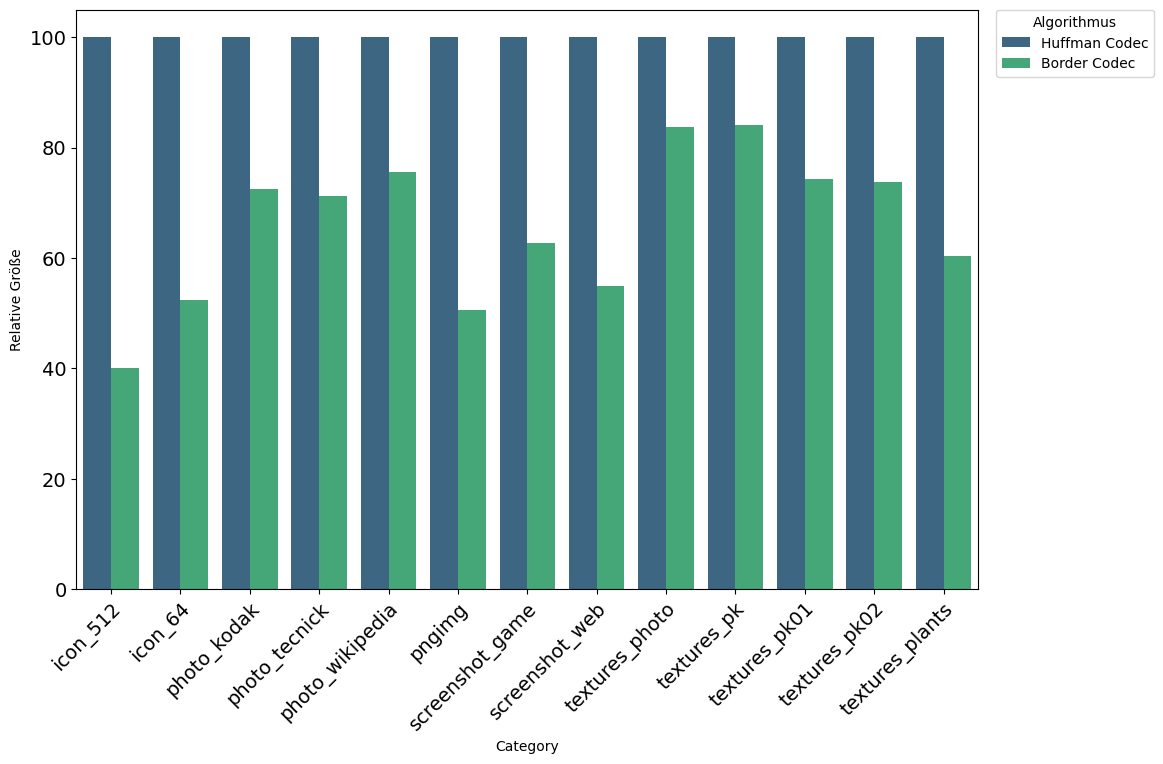

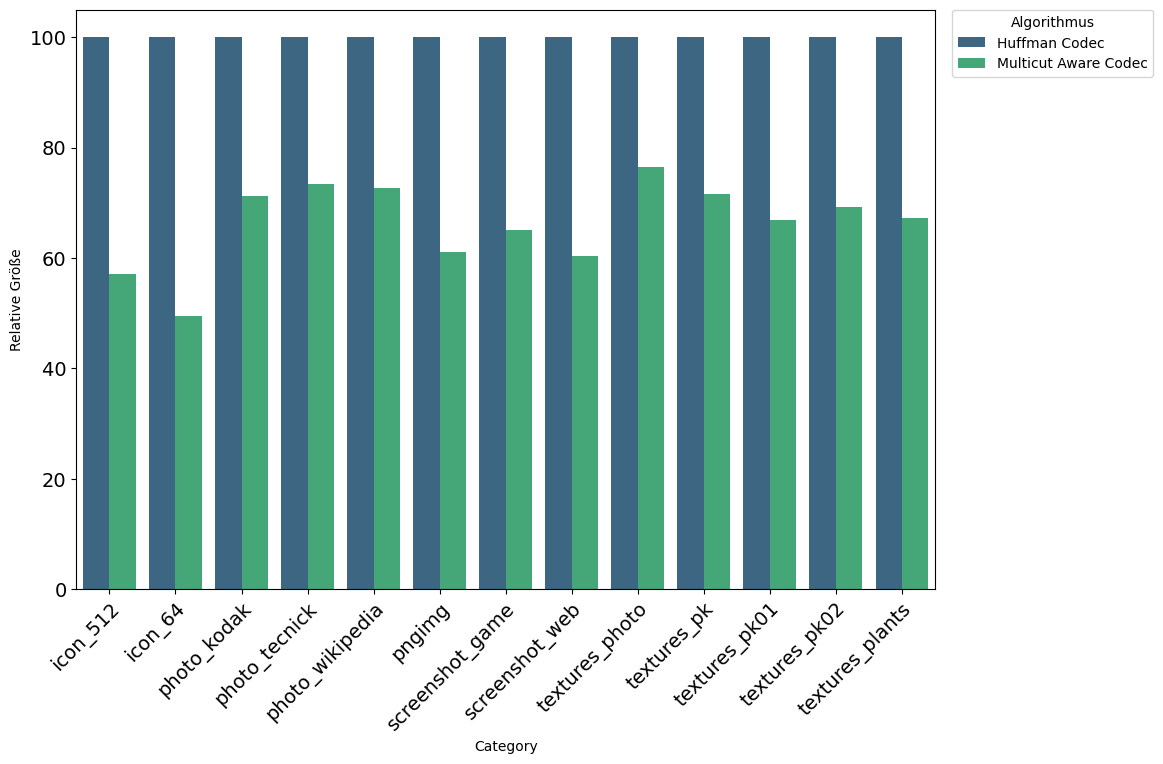

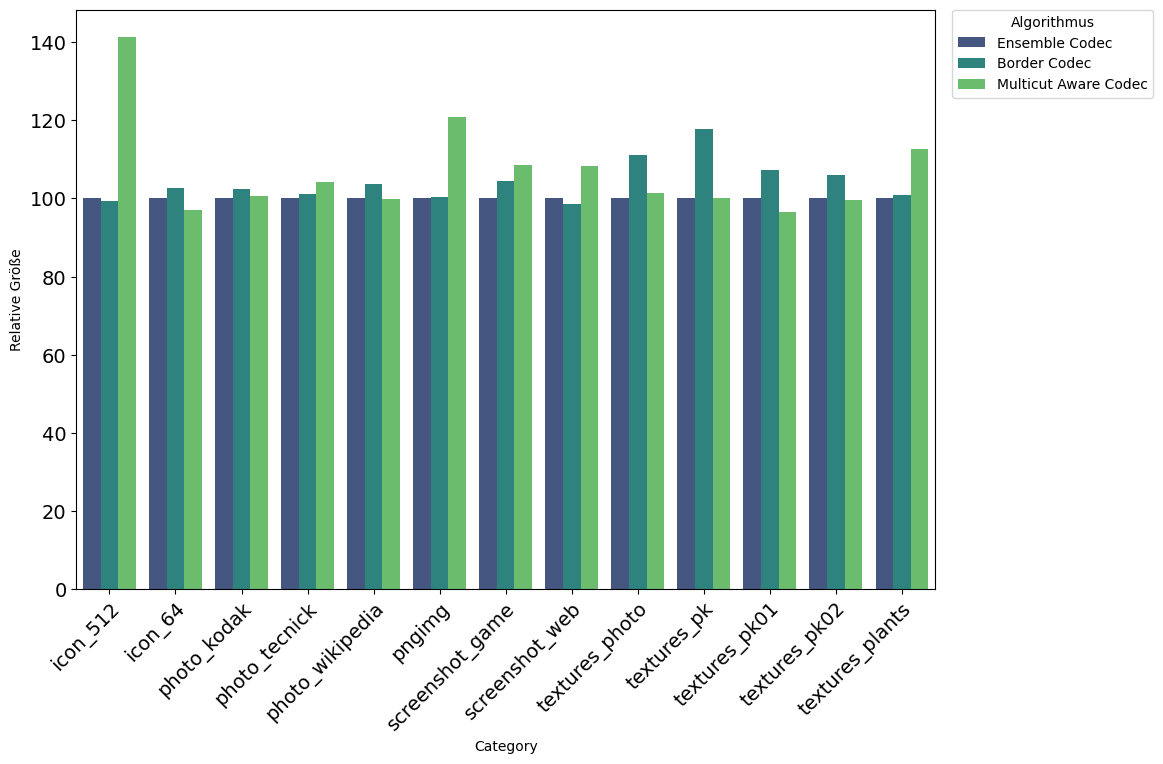

In [9]:
qname = "medium"
compare_results(sizes_huff_25, sizes_border_25, "Huffman Codec", "Border Codec", f"multicut-comparisons/huff_v_border_{qname}.png")
compare_results(sizes_huff_25, sizes_multicut_aware_25, "Huffman Codec", "Multicut Aware Codec", f"multicut-comparisons/huff_v_multicut_aware_{qname}.png")
compare_results(sizes_ensemble_25, sizes_border_25, "Ensemble Codec", "Border Codec", f"multicut-comparisons/ensemble_v_border_v_multicut{qname}.png", 
                sizes_multicut_aware_25, "Multicut Aware Codec")

In [10]:
sizes_huff_50 = compute_mask_sizes(mc.HUFFMAN, 50)
sizes_border_50 = compute_mask_sizes(mc.BORDER, 50)
sizes_multicut_aware_50 = compute_mask_sizes(mc.MULTICUT_AWARE, 50)
sizes_ensemble_50  = compute_mask_sizes(mc.ENSEMBLE, 50)

Processing: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]
13it [01:58,  9.11s/it]
Processing: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]
13it [03:19, 15.34s/it]
Processing: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]
13it [02:59, 13.84s/it]
Processing: 100%|██████████| 18/18 [00:08<00:00,  2.24it/s]
13it [03:16, 15.13s/it]


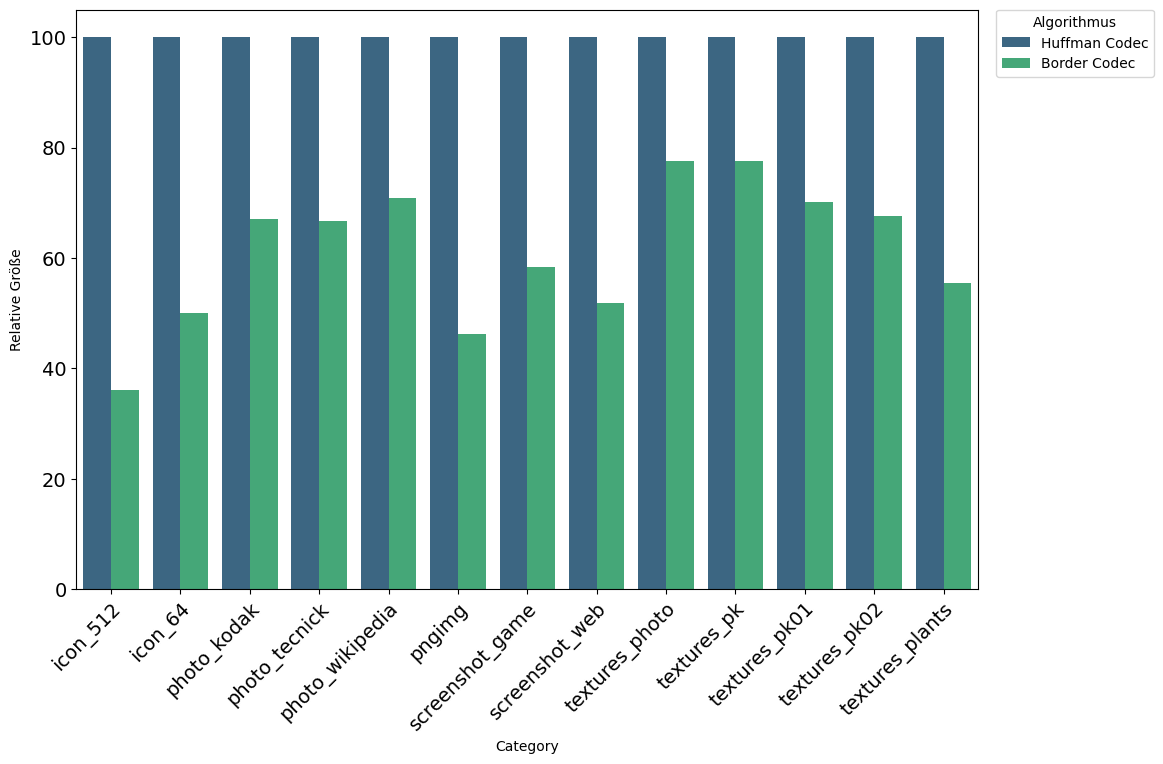

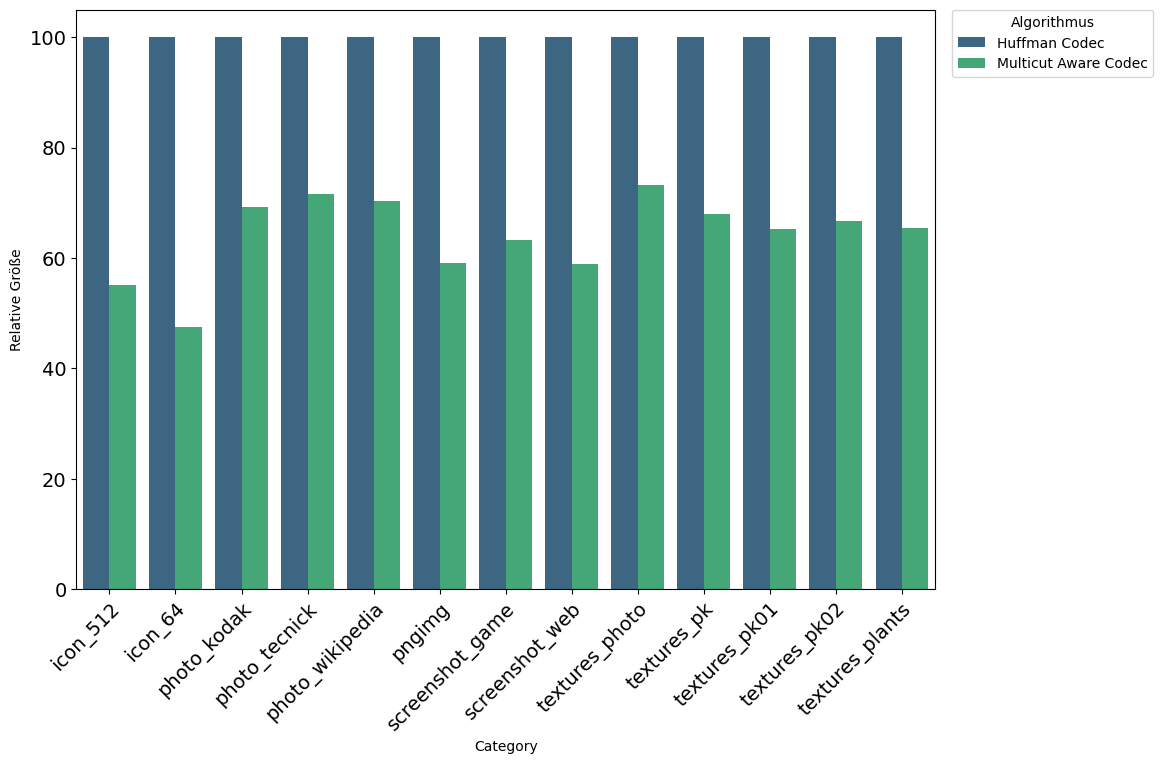

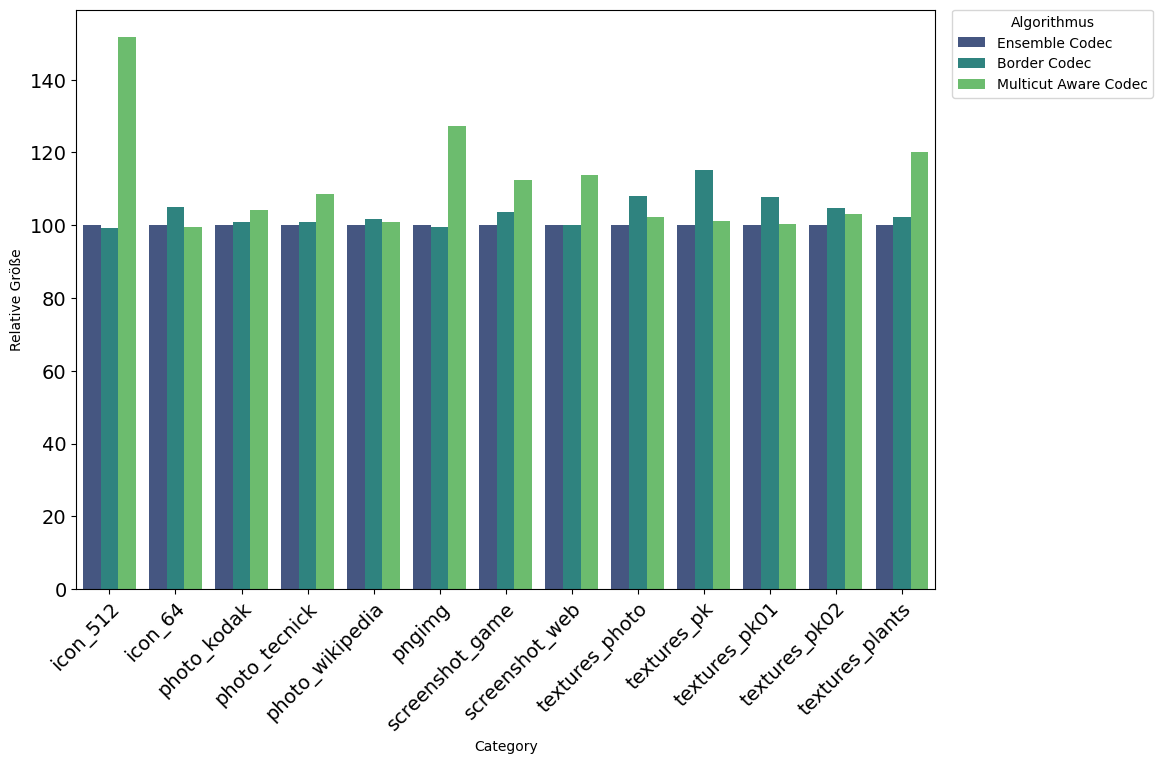

In [11]:
qname = "low"
compare_results(sizes_huff_50, sizes_border_50, "Huffman Codec", "Border Codec", f"multicut-comparisons/huff_v_border_{qname}.png")
compare_results(sizes_huff_50, sizes_multicut_aware_50, "Huffman Codec", "Multicut Aware Codec", f"multicut-comparisons/huff_v_multicut_aware_{qname}.png")
compare_results(sizes_ensemble_50, sizes_border_50, "Ensemble Codec", "Border Codec", f"multicut-comparisons/ensemble_v_border_v_multicut{qname}.png", 
                sizes_multicut_aware_50, "Multicut Aware Codec")